In [1]:
import pandas as pd

from edgedroid.data.load import load_default_exec_time_data

_, _, imp_bins, _ = load_default_exec_time_data()
imp_bins[-1]

Interval(3.1982650678242854, inf, closed='left')

In [2]:
ttfs = (("low", 0), ("high", 3.2))
startup_window = 20
num_samples = 5000

In [3]:
from edgedroid.models.timings import *
import itertools as it
import numpy as np

results = pd.DataFrame(columns=["model", "neuroticism", "ttf", "exec_time"], index=np.arange(0, 8 * num_samples))
current_idx = -1

for mcls, neuroticism, (ttf_tag, ttf) in it.product((TheoreticalExecutionTimeModel, EmpiricalExecutionTimeModel), (0.0, 1.0), ttfs):
    model = mcls.from_default_data(neuroticism=neuroticism)
    for _ in range(startup_window):
        model.advance(ttf)

    for _ in range(num_samples):
        current_idx += 1
        results.at[current_idx, "model"] = mcls.__name__
        results.at[current_idx, "neuroticism"] = "high" if neuroticism > 0.5 else "low"
        results.at[current_idx, "exec_time"] = float(model.get_execution_time())
        results.at[current_idx, "ttf"] = ttf_tag

        model.advance(ttf)


results["neuroticism"] = results["neuroticism"].astype(pd.CategoricalDtype(["low", "high"], ordered=True))
results["ttf"] = results["ttf"].astype(pd.CategoricalDtype(["low", "high"], ordered=True))
results["exec_time"] = results["exec_time"].astype(float)
results

,model,neuroticism,ttf,exec_time
0,TheoreticalExecutionTimeModel,low,low,4.586676
1,TheoreticalExecutionTimeModel,low,low,8.631655
2,TheoreticalExecutionTimeModel,low,low,3.828750
3,TheoreticalExecutionTimeModel,low,low,3.729992
4,TheoreticalExecutionTimeModel,low,low,4.653333
...,...,...,...,...
39995,EmpiricalExecutionTimeModel,high,high,9.446460
39996,EmpiricalExecutionTimeModel,high,high,3.300936
39997,EmpiricalExecutionTimeModel,high,high,11.390658
39998,EmpiricalExecutionTimeModel,high,high,3.313133


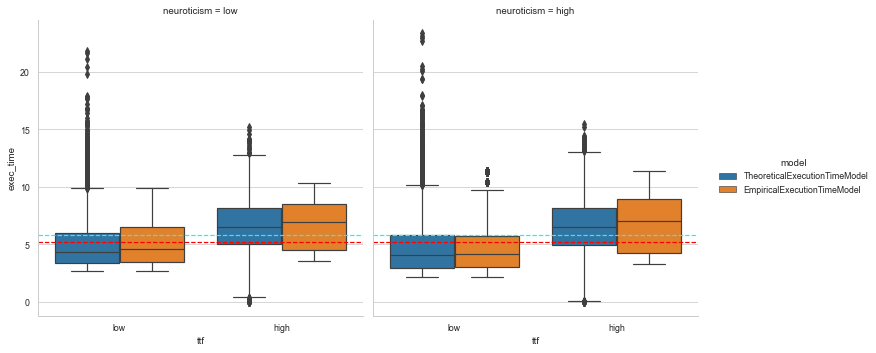

In [11]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper")
sns.set_style("whitegrid")

naive_model = NaiveExecutionTimeModel.from_default_data()
naive_exec_time = naive_model.get_execution_time()

prob_naive_model = ProbabilisticNaiveExecutionTimeModel.from_default_data()
prob_naive_exec_time = prob_naive_model.get_expected_execution_time()


fg = sns.catplot(
    kind="box",
    errorbar=("ci", 95),
    data=results,
    hue="model",
    y="exec_time",
    x="ttf",
    col="neuroticism"
)
fg.refline(y=naive_exec_time, color="red")
fg.refline(y=prob_naive_exec_time, color="cyan")
plt.show()

In [5]:
(
    results
    .groupby(["neuroticism", "model", "ttf"])
    ["exec_time"]
    .describe()
)

count      mean       std  \
neuroticism model                         ttf                                
low         EmpiricalExecutionTimeModel   low   5000.0  5.124710  2.115843   
                                          high  5000.0  6.603583  2.313688   
            TheoreticalExecutionTimeModel low   5000.0  5.080251  2.335268   
                                          high  5000.0  6.622687  2.337633   
high        EmpiricalExecutionTimeModel   low   5000.0  4.931671  2.694768   
                                          high  5000.0  6.519110  2.470009   
            TheoreticalExecutionTimeModel low   5000.0  4.856215  2.644860   
                                          high  5000.0  6.576355  2.438681   

                                                     min       25%       50%  \
neuroticism model                         ttf                                  
low         EmpiricalExecutionTimeModel   low   2.724505  3.512730  4.618917   
                                          high  3.539722  4.544413  6.973581   
            TheoreticalExecutionTimeModel low   2.722053  3.418865  4.381806   
                                          high  0.000000  5.080421  6.559665   
high        EmpiricalExecutionTimeModel   low   2.181759  3.036964  4.203019   
                                          high  3.300936  4.233891  7.024530   
            TheoreticalExecutionTimeModel low   2.178299  2.953967  4.078918   
                                          high  0.000000  4.953309  6.535831   

                                                     75%        max  
neuroticism model                         ttf                        
low         EmpiricalExecutionTimeModel   low   6.561004   9.930327  
                                          high  8.505258  10.331286  
            TheoreticalExecutionTimeModel low   6.000011  21.827431  
                                          high  8.208100  15.193800  
high        EmpiricalExecutionTimeModel   low   5.739383  11.406472  
                                          high  8.988861  11.390658  
            TheoreticalExecutionTimeModel low   5.838996  23.372329  
                                          high  8.201408  15.445107